# Project (2) NASA Data Acquisation, Visualization, and Analysis 

 During the course we have to work with two data visualization and analysis projects. 
 This is the second project. In this project we will work on Pyhton notebook "5_nasa_data_collection_and_visualization.ipynb" and focuses on the acquisition and visualization of NASA data.and with its associated source folder (src) that consist of proejc source files.   

In [34]:
# The code makes sure that once there is change in the 'src/' folder, the 
# change will be automatically reloaded in the notebook.
%reload_ext autoreload
%autoreload 2
%aimport src

## NASA Data Acquisation

### Task 1: Understanding the NASA API and Data Collection

- The first taks is to register ourselves for a NASA API key and get knowing the different types of data that the API provides.
- Then we will run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- We will extract and analyze the distinct data elements provided for each NEO to gain a comprehensive understanding.

In [35]:
# We import all necersary liberaries at først: 
import requests
import time
from datetime import datetime, timedelta
from getpass import getpass
import json
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import plotly.express as px
import matplotlib.dates as mdates
import statistics

In [36]:
# This python script ask and register our given NASA Api-key:

# Set your NASA API KEY, this step asks you to enter your API KEY.
# (The input box may be float in the top on your editor.)
#api_key = getpass()

# The code is commented because we have loaded the data and for not being bothered

In [37]:
# This code block for fetching data from api, see use_data_from_local_file bool
"""
# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=num_days)  # 1 year later
# change above to full year!
# Initialize a list to store the data
data = []

# Fetch data from the NASA API 7 days at a time
# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"
# You can look into the example query in the link below to see what the data look like:
# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY
current_date = start_date
while current_date < end_date and use_data_from_local_file == False:
    next_date = min(current_date + timedelta(days=7), end_date)
    # print("Current date: ", current_date)
    # print("Next date: ", next_date)
    response = requests.get(f'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strftime("%Y-%m-%d")}&api_key={api_key}')
    data.append(response.json())
    current_date = next_date
    time.sleep(1)  # To avoid hitting the rate limit
"""
# Now 'data' contains the NEO data for the 1-year period

'\n# Set the start and end dates for the data you want to fetch\nstart_date = datetime.strptime(\'2022-01-01\', \'%Y-%m-%d\')\nend_date = start_date + timedelta(days=num_days)  # 1 year later\n# change above to full year!\n# Initialize a list to store the data\ndata = []\n\n# Fetch data from the NASA API 7 days at a time\n# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"\n# You can look into the example query in the link below to see what the data look like:\n# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY\ncurrent_date = start_date\nwhile current_date < end_date and use_data_from_local_file == False:\n    next_date = min(current_date + timedelta(days=7), end_date)\n    # print("Current date: ", current_date)\n    # print("Next date: ", next_date)\n    response = requests.get(f\'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strft

In [38]:
# This code will utilize data from a local file as opposed to retrieving it from an external source.
use_data_from_local_file = True
num_days = 367

In [39]:
# This code block for fetching data from local file, see use_data_from_local_file bool
if use_data_from_local_file:
    file_path = 'src/a_years_nasa_data.json' 
    with open(file_path) as f:
        data = json.load(f)
    
# Check the date coverage of your data.
print("Number of days of data used: ", num_days)
print("Number of weeks of data used:", len(data))

Number of days of data used:  367
Number of weeks of data used: 53


In [40]:
# An empty list called neo_data is created to store the NEOs.

neo_data = []
for d in data:
   neo_data += list(d['near_earth_objects'].keys())

# Removing duplicates in loaded NEOs data using a set
neo_data = list(set(neo_data))

# Sort the dates
neo_data.sort()

#print(sorted(neo_data))

In [41]:
#The code imports a function called 
#get_a_random_chunk_property from a src.utils
from src.utils import get_a_random_chunk_property

In [42]:
get_a_random_chunk_property(data)

date: 2022-07-10
NEO name: (2022 SV55)
absolute_magnitude_h: 23.14


## Data Analysis
For the remaining tasks, we have to organize the data as **pd.DataFrame** so as to suit the specific need in each task. 

### Task 2:  Data science and analytics works.

1. Calculate the average size of the NEOs for each day.
2. Determine the proportion of NEOs that are potentially hazardous.
3.  Find the NEO with the closest approach distance for each day.
4.  Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

#### Task 2.1 (Calculate the average size of the NEOs for each day)

In [43]:
from src.utils import calculate_average_neo_size
## Data was as list and here we convert the data list into a dictionary:

data_dict = {}
for item in data:
    for date, neos in item['near_earth_objects'].items():
        if date not in data_dict:
            data_dict[date] = []
        data_dict[date].extend(neos)

# To check the date coverage of the data.
dates_contained_in_data = list(data_dict.keys())


average_sizes = calculate_average_neo_size(data_dict)

# To convert the dictionary to a DataFrame
average_size_df = pd.DataFrame.from_dict(average_sizes, orient='index', columns=['average_size'])

# we sort the DataFrame by date 
average_size_df = average_size_df.sort_index()

# enumerate for index
#average_size_df = average_size_df.reset_index(names='date')

# Print the DataFrame
print(average_size_df)

            average_size
2022-01-01    164.069506
2022-01-02    113.283811
2022-01-03     28.178929
2022-01-04     80.179344
2022-01-05    177.148967
...                  ...
2022-12-29    188.916640
2022-12-30    137.482136
2022-12-31     52.291388
2023-01-01    305.094598
2023-01-02    183.898691

[367 rows x 1 columns]


In [44]:
average_size_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, 2022-01-01 to 2023-01-02
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   average_size  367 non-null    float64
dtypes: float64(1)
memory usage: 5.7+ KB


##### Task 2.2 (Determine the proportion of NEOs that are potentially hazardous.) & Task 2.3 (Find the NEO with the closest approach distance for each day.)


In [45]:
# - Determine the proportion of NEOs that are potentially hazardous.
# - Find the NEO with the closest approach distance for each day.

# data is a list of dicts containing json response data
# DATA TYPE: <class 'list'>
# DATA0 TYPE: <class 'dict'>
# NEO TYPE: <class 'dict'>
# DATE VALUE TYPE: <class 'list'> of dicts
# INDEX TYPE <class 'tuple'>

# lists to be converted into dataframes
daily_neo_list = [] # list of lists, each nested list for one day
daily_hazardous_list = [] # list of lists, each nested list for one day
full_relevant_approach_df_list = [] # list of dataframes, each dataframe for one neo entry

# count of hazardous asteroids for proportion calculation
total_hazardous_count = 0
total_non_hazardous_count = 0

# for removing duplicates
do_not_skip_very_first_date = True
skip_first_day_of_week = True

# loop through list of dicts containing data
for val in range(len(data)):
    neo = data[val]['near_earth_objects']
    skip_first_day_of_week = True
    
    # each dict in list contains 8 days of data, so one must be removed to avoid duplicates
    for neo_object in sorted(neo.items()):
        if skip_first_day_of_week == True: # run once at beginning of loop
            if do_not_skip_very_first_date == True: # run once at very beginning
                do_not_skip_very_first_date = False
            skip_first_day_of_week = False
            continue
            
        # print("Date:", neo_object[0])
        neo_entry_date = neo_object[0]
        
        # close approach work
        expanded_neo_df = pd.json_normalize(neo, record_path=neo_entry_date) # expand on neo entry date, unfiltered
        expanded_approach_df = pd.json_normalize(neo[neo_entry_date], 'close_approach_data', 
                                                 ['neo_reference_id', 'name', 'is_potentially_hazardous_asteroid', 'absolute_magnitude_h', 
                                                  ['estimated_diameter', 'meters', 'estimated_diameter_min'], 
                                                  ['estimated_diameter', 'meters', 'estimated_diameter_max']]) # get relevant columns for close approach analysis
        relevant_expanded_approach_df = expanded_approach_df[['close_approach_date', 'orbiting_body', 'relative_velocity.kilometers_per_second', 
                                                              'miss_distance.kilometers', 'name', 'is_potentially_hazardous_asteroid', 'absolute_magnitude_h', 
                                                              'estimated_diameter.meters.estimated_diameter_min', 'estimated_diameter.meters.estimated_diameter_max']] # get relevant columns for scatter plot
        
        full_relevant_approach_df_list.append(relevant_expanded_approach_df) # add each neo entry df to list
        
        # get other col data based on closest neo for the day
        min_val = expanded_approach_df['miss_distance.kilometers'].min() # string
        min_id = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['neo_reference_id'] # pd series
        min_name = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['name'] # pd series
        min_hazardous = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['is_potentially_hazardous_asteroid'] # pd series
        min_magnitude = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['absolute_magnitude_h'] # pd series
        
        # combine into list for conversion into df
        neo_single_entry_list = min_id.tolist() + min_name.tolist() + min_hazardous.tolist() + min_magnitude.tolist()
        neo_single_entry_list.append(min_val)
        neo_single_entry_list.insert(0, neo_entry_date)
        daily_neo_list.append(neo_single_entry_list)

        # hazardous asteroid work
        non_hazardous_count = len(expanded_neo_df[expanded_neo_df['is_potentially_hazardous_asteroid']==False])
        total_non_hazardous_count += non_hazardous_count
        hazardous_count = len(expanded_neo_df[expanded_neo_df['is_potentially_hazardous_asteroid']==True])
        total_hazardous_count += hazardous_count

        # calculate proportion by day
        dangerous_proportion = hazardous_count/non_hazardous_count
        daily_hazardous_list.append([neo_entry_date, dangerous_proportion])

# note that initially the start and end of the week-long data is duplicated and one needs to be dropped

# df with enumerated index, various descriptive fields incl approach data
full_relevant_approach_df = pd.concat(full_relevant_approach_df_list)
full_relevant_approach_df['miss_distance.kilometers'] = full_relevant_approach_df['miss_distance.kilometers'].astype(float) # convert to float, since object type won't work
full_relevant_approach_df['absolute_magnitude_h'] = full_relevant_approach_df['absolute_magnitude_h'].astype(float) # convert to float, since object type won't work
full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_min'] = full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_min'].astype(float) # convert to float, since object type won't work
full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_max'] = full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_max'].astype(float) # convert to float, since object type won't work
full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_avg'] = (full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_min'] + full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_max'])/2 # calculate average diameter

# df with date as index, neo id, neo name, hazardous bool, abs magnitude and approach dist
neo_df = pd.DataFrame(daily_neo_list, columns=['date', 'neo id', 'neo name', 'hazardous', 'abs magnitude', 'dist'])
neo_df['dist'] = neo_df['dist'].astype(float) # convert to float, since object type won't work
neo_df = neo_df.drop_duplicates()
neo_df = neo_df.reset_index(drop=True)
neo_df = neo_df.set_index('date') # set index to date
neo_df.index.name = None # remove date label

# df with date as index, hazardous proportion
dangerous_df = pd.DataFrame(daily_hazardous_list, columns=['date', 'proportion'])
dangerous_df = dangerous_df.drop_duplicates()
dangerous_df = dangerous_df.reset_index(drop=True)
dangerous_df = dangerous_df.set_index('date') # set index to date
dangerous_df.index.name = None # remove date label

In [46]:
# - Use statistical methods to analyze the data. 
# For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. 
# Determine if the size of a NEO is correlated with whether it is potentially hazardous.

from src.utils import analyze_neo_data

result = analyze_neo_data(data)
# print(json.dumps(result, indent=4))

# print(full_relevant_approach_df[['is_potentially_hazardous_asteroid', 'estimated_diameter.meters.estimated_diameter_avg']].describe())
# print(full_relevant_approach_df[['is_potentially_hazardous_asteroid', 'estimated_diameter.meters.estimated_diameter_avg']].corr())

# more columns of data to see what columns have high correlation
# print(full_relevant_approach_df[['absolute_magnitude_h', 'miss_distance.kilometers', 'relative_velocity.kilometers_per_second', 'is_potentially_hazardous_asteroid', 'estimated_diameter.meters.estimated_diameter_avg']].corr())

## Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

#### Task 3.1 (Create a line plot of the number of NEOs per week.)

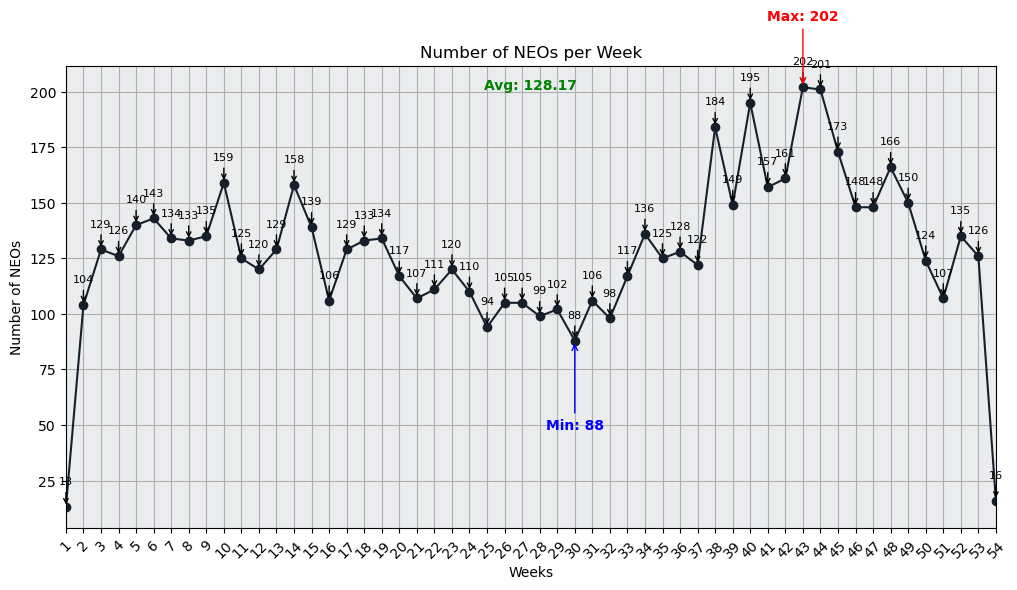

In [50]:
# Convert the 'close_approach_date' column to datetime type
full_relevant_approach_df['close_approach_date'] = pd.to_datetime(full_relevant_approach_df['close_approach_date'])

# Group the NEOs by week and count the number of NEOs per week
neos_per_week = full_relevant_approach_df.groupby(pd.Grouper(key='close_approach_date', freq='W')).size()

# Create a gradient color map for the line plot
color_map = mcolors.LinearSegmentedColormap.from_list('ColorMap', ['#17202A', '#E74C3C'])

# Create a list of markers for the line plot
markers = ['o', 's', '^', 'D', 'v', 'p']

# Create the line plot
plt.figure(figsize=(12, 6))
neos_per_week.plot(color=color_map(np.linspace(0, 1, len(neos_per_week))), marker=np.random.choice(markers))
plt.xlabel('Weeks')
plt.ylabel('Number of NEOs')
plt.title('Number of NEOs per Week')
plt.grid(True)

# Add a gradient background
ax = plt.gca()
ax.set_facecolor('#EAECEE')

# Annotate all data points
for index, value in neos_per_week.items():
    plt.annotate(value, xy=(index, value), xytext=(index, value + 10), ha='center', fontsize=8,
                 arrowprops=dict(arrowstyle='->', color='black'))

# Annotate maximum value
max_value = neos_per_week.max()
max_week = neos_per_week.idxmax()
plt.annotate(f'Max: {max_value}', xy=(max_week, max_value), xytext=(max_week, max_value + 30),
             ha='center', fontsize=10, fontweight='bold', color='red',
             arrowprops=dict(arrowstyle='->', color='red'))

# Annotate minimum value (week 30)
min_value = 88
min_week = neos_per_week.index[29]  # Index 29 corresponds to week 30
plt.annotate(f'Min: {min_value}', xy=(min_week, min_value), xytext=(min_week, min_value - 40),
             ha='center', fontsize=10, fontweight='bold', color='blue',
             arrowprops=dict(arrowstyle='->', color='blue'))

# Annotate average value
avg_value = neos_per_week.mean()
plt.annotate(f'Avg: {avg_value:.2f}', xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', fontsize=10, fontweight='bold', color='green')

# Set the x-axis tick labels as week numbers
week_numbers = range(1, len(neos_per_week) + 1)
plt.xticks(neos_per_week.index, week_numbers, rotation=45)

plt.show()





The plot provides an overview of the variation in the number of NEOs observed per week, highlighting the maximum, minimum, and average values. It helps in understanding the distribution and trends of NEO sightings over time.

X-axis: Represents the weeks over the timeline, indicating the duration covered by the dataset.

Y-axis: Represents the number of NEOs (Near-Earth Objects) observed during each week.

The week 1 and week 54 contain only 2 days which shows very less number of 

Line Plot: The line plot shows the trend of NEO counts per week. Each data point on the line represents the number of NEOs observed during a specific week.

##### Task 3.2 (Create a histogram of the distribution of NEO sizes.)

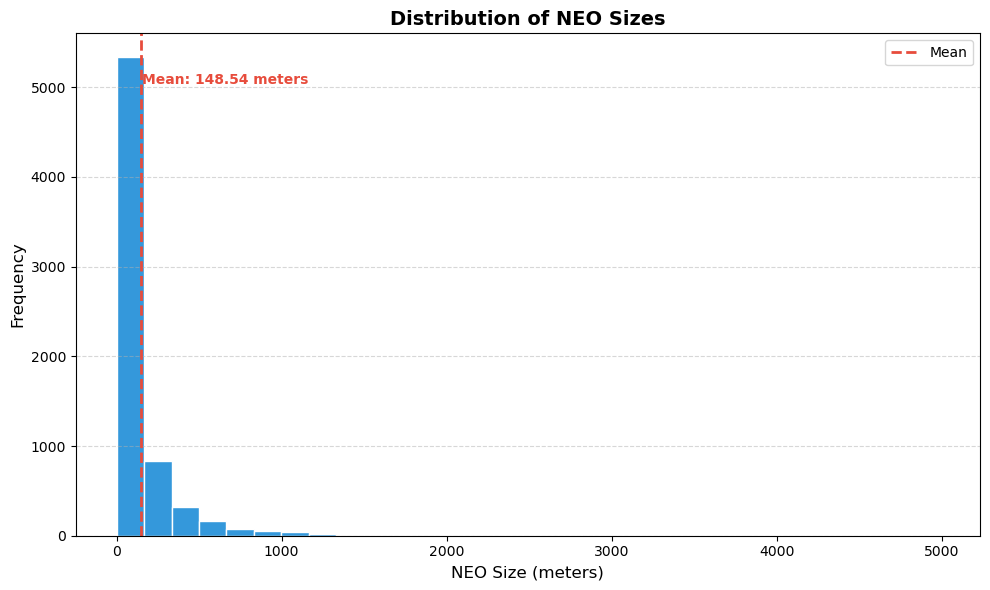

In [51]:
# Extract the NEO sizes
neo_sizes = full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_avg']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(neo_sizes, bins=30, color='#3498DB', edgecolor='white')

# Set the labels and title
plt.xlabel('NEO Size (meters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of NEO Sizes', fontsize=14, fontweight='bold')

# Add gridlines
plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)

# Add a vertical line for the mean
mean_size = neo_sizes.mean()
plt.axvline(mean_size, color='#E74C3C', linestyle='dashed', linewidth=2, label='Mean')

# Add legend
plt.legend()

# Add text annotation for the mean
plt.text(mean_size + 5, plt.ylim()[1] * 0.9, f'Mean: {mean_size:.2f} meters',
         color='#E74C3C', fontsize=10, fontweight='bold')

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


The plot provides insights into the distribution of NEO sizes, highlighting the frequency of NEOs within specific size ranges. It also emphasizes the mean size, giving an indication of the average size of the observed NEOs.

X-axis: Represents the range of NEO sizes in meters. The axis is divided into bins, which group the NEO sizes together.

Y-axis: Represents the frequency or count of NEOs falling within each bin. It indicates the number of NEOs with sizes within a specific range.

#### Task 3.3 (Create a bar plot of the average NEO size per week.)

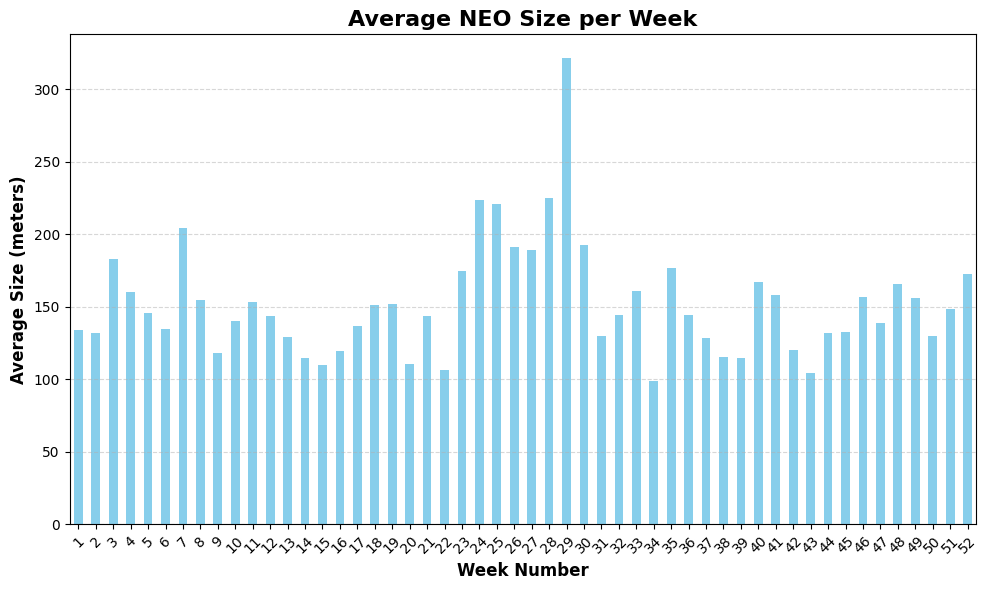

In [52]:
# Convert the 'close_approach_date' column to datetime type
full_relevant_approach_df['close_approach_date'] = pd.to_datetime(full_relevant_approach_df['close_approach_date'])

# Group the NEOs by week and calculate the average size
avg_size_per_week = full_relevant_approach_df.groupby(pd.Grouper(key='close_approach_date', freq='W'))['estimated_diameter.meters.estimated_diameter_avg'].mean()

# Remove the first and last weeks from the DataFrame because both first week and last week in dataFrame don't contain 7 days. 
avg_size_per_week = avg_size_per_week[1:-1]

# Create the bar plot
plt.figure(figsize=(10, 6))
avg_size_per_week.plot(kind='bar', color='skyblue')

# Set the plot title and axis labels
plt.title('Average NEO Size per Week', fontsize=16, fontweight='bold')
plt.xlabel('Week Number', fontsize=12, fontweight='bold')
plt.ylabel('Average Size (meters)', fontsize=12, fontweight='bold')

# Set x-axis tick labels as week numbers
week_numbers = avg_size_per_week.index.isocalendar().week
plt.xticks(range(len(week_numbers)), week_numbers, rotation=45)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add a background color for the annotations
bbox_props = dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0.5)

# Increase the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

This plot shows the average size of Near-Earth Objects (NEOs) each week. It helps us see how the size changes over time. By looking at the bars, we can understand the trends and differences in size from one week to another. This information is important for studying NEOs and understanding the risks they may pose if they were to impact Earth.

X-axis: Represents the week numbers. Each bar on the plot corresponds to a specific week.

Y-axis: Represents the average size of NEOs in meters. The values on the Y-axis indicate the average size observed for NEOs during each week.

##### Task 3.4 (Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. Be creative!)

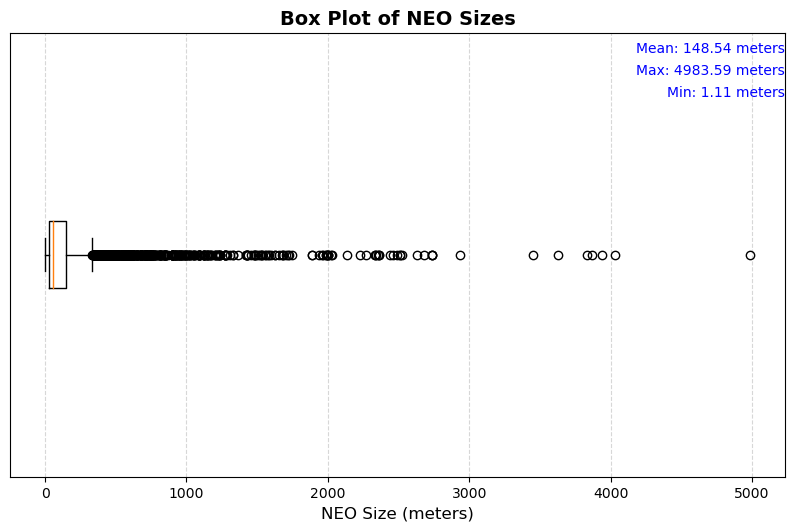

In [53]:
# Extract the NEO sizes
neo_sizes = full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_avg']

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(neo_sizes, vert=False)

# Set the labels and title
plt.xlabel('NEO Size (meters)', fontsize=12)
plt.title('Box Plot of NEO Sizes', fontsize=14, fontweight='bold')

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks([])  # Remove y-axis tick labels

# Add horizontal grid lines
plt.grid(True, axis='x', linestyle='dashed', alpha=0.5)

# Calculate statistics
mean_size = neo_sizes.mean()
max_size = neo_sizes.max()
min_size = neo_sizes.min()

x_offset = 0.1  # Adjust the value as needed


# Define the annotation positions in the right corner of the plot
annotation_x = plt.xlim()[1] + x_offset

# Create a list of annotations for mean, max, and min
annotations = [
    f'Mean: {mean_size:.2f} meters',
    f'Max: {max_size:.2f} meters',
    f'Min: {min_size:.2f} meters'
]

# Add annotations in the right corner as a list
for i, annotation in enumerate(annotations):
    annotation_y = plt.ylim()[1] - (i + 1) * 0.05
    plt.annotate(annotation, xy=(annotation_x, annotation_y), xytext=(annotation_x, annotation_y),
                 ha='right', va='bottom', color='b')

# Adjust the plot layout to accommodate the annotations
plt.subplots_adjust(top=0.85)

# Show the plot
plt.show()




This plot helps visualize the distribution of NEO sizes and provides key statistical measures to describe the central tendency and variability of the data. It can be used to identify potential outliers, assess the spread of the data, and compare different subsets of NEO sizes.





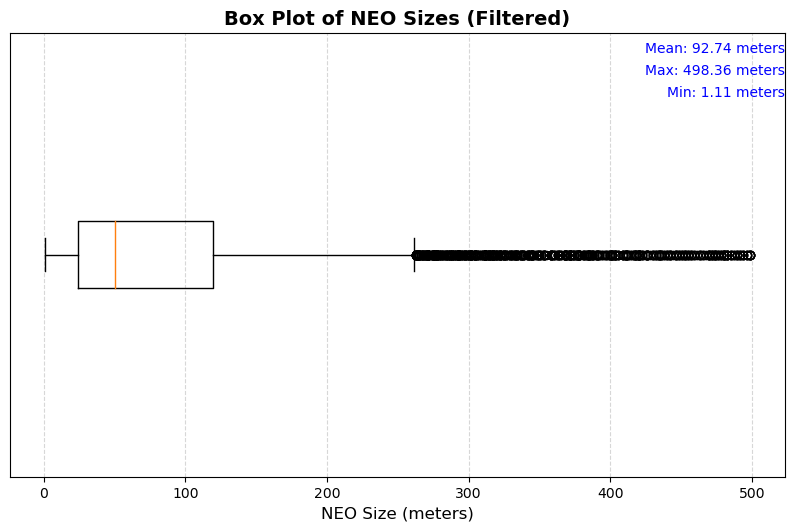

In [54]:
# Filter the NEO sizes to remove objects over 3000 meters
filtered_neo_sizes = neo_sizes[neo_sizes <= 500]

# Create the box plot with the filtered data
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_neo_sizes, vert=False)

# Set the labels and title
plt.xlabel('NEO Size (meters)', fontsize=12)
plt.title('Box Plot of NEO Sizes (Filtered)', fontsize=14, fontweight='bold')

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks([])  # Remove y-axis tick labels

# Add horizontal grid lines
plt.grid(True, axis='x', linestyle='dashed', alpha=0.5)

# Calculate statistics
mean_size = filtered_neo_sizes.mean()
max_size = filtered_neo_sizes.max()
min_size = filtered_neo_sizes.min()

# Define the annotation positions in the right corner of the plot
annotation_x = plt.xlim()[1] + x_offset

# Create a list of annotations for mean, max, and min
annotations = [
    f'Mean: {mean_size:.2f} meters',
    f'Max: {max_size:.2f} meters',
    f'Min: {min_size:.2f} meters'
]

# Add annotations in the right corner as a list
for i, annotation in enumerate(annotations):
    annotation_y = plt.ylim()[1] - (i + 1) * 0.05
    plt.annotate(annotation, xy=(annotation_x, annotation_y), xytext=(annotation_x, annotation_y),
                 ha='right', va='bottom', color='b')

# Adjust the plot layout to accommodate the annotations
plt.subplots_adjust(top=0.85)

# Show the plot
plt.show()


The above boxplot is efter removing NEOs larger than 500 meter in order to make the box plot readable 

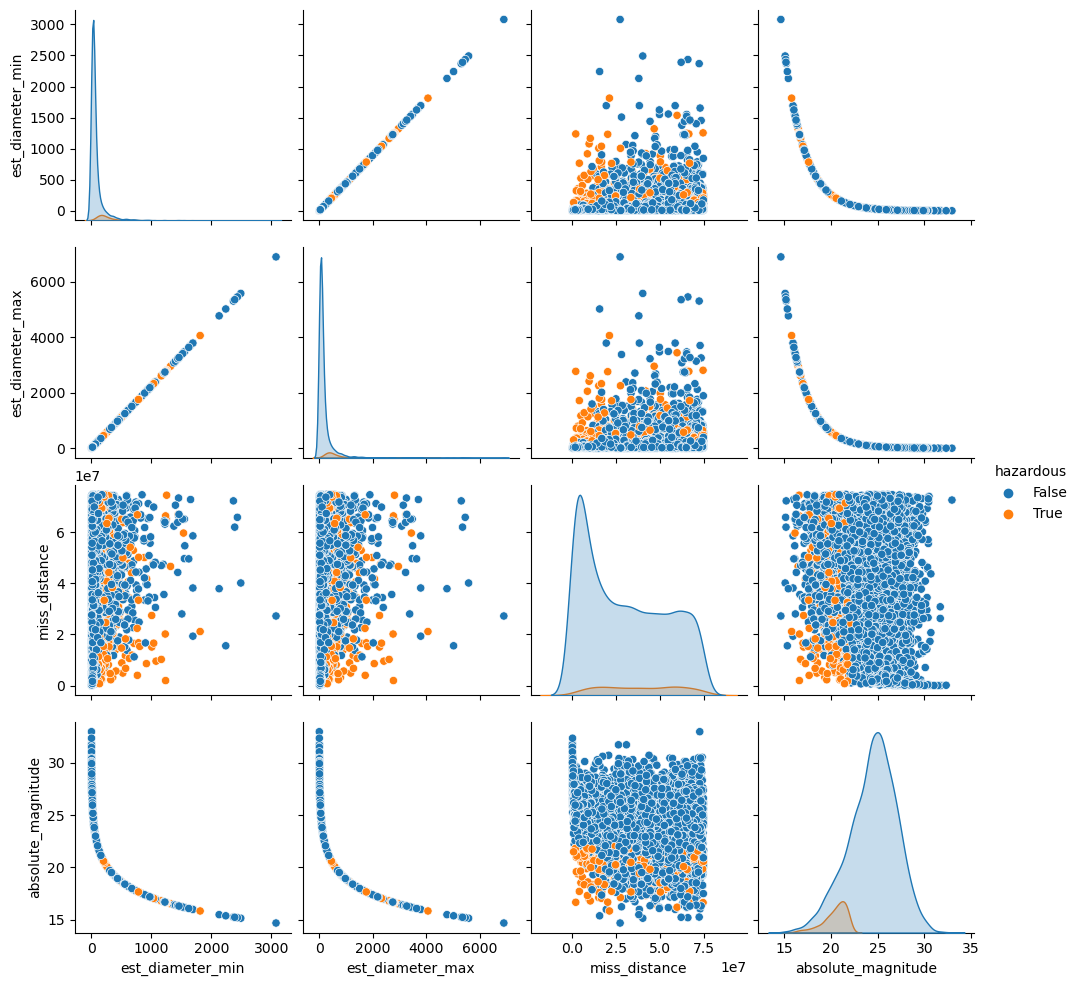

In [55]:


# Select the relevant columns from your dataset
selected_data = full_relevant_approach_df[['estimated_diameter.meters.estimated_diameter_min',
                           'estimated_diameter.meters.estimated_diameter_max',
                           'relative_velocity.kilometers_per_second',
                           'miss_distance.kilometers',
                           'absolute_magnitude_h',
                           'is_potentially_hazardous_asteroid']]

# Rename the columns if needed
selected_data = selected_data.rename(columns={'estimated_diameter.meters.estimated_diameter_min': 'est_diameter_min',
                                              'estimated_diameter.meters.estimated_diameter_max': 'est_diameter_max',
                                              'relative_velocity.kilometers_per_second': 'relative_velocity',
                                              'miss_distance.kilometers': 'miss_distance',
                                              'absolute_magnitude_h': 'absolute_magnitude',
                                              'is_potentially_hazardous_asteroid': 'hazardous'})

# Create the pair plot
sns.pairplot(data=selected_data, hue='hazardous')

# Show the plot
plt.show()


The plot shown is a pair plot that visualizes the relationships between different variables in the dataset. It provides a scatter plot matrix where each variable is plotted against every other variable in the dataset. 

The points on the scatter plots are color-coded based on the "hazardous" classification of the asteroids.
The color indicates whether the asteroid is potentially hazardous (True) or not (False). This color distinction helps in visually identifying the potential hazardous asteroids in the dataset.

In [56]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6921 entries, 0 to 15
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   est_diameter_min    6921 non-null   float64
 1   est_diameter_max    6921 non-null   float64
 2   relative_velocity   6921 non-null   object 
 3   miss_distance       6921 non-null   float64
 4   absolute_magnitude  6921 non-null   float64
 5   hazardous           6921 non-null   object 
dtypes: float64(4), object(2)
memory usage: 378.5+ KB


In [57]:
selected_data.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,40.230458,89.958039,10.1548261794,2.118674e+07,24.1,False
1,48.367649,108.153351,13.5100245697,2.582431e+07,23.7,False
2,66.765941,149.293183,20.4077209528,7.408668e+07,23.0,False
3,22.108281,49.435619,8.4332699552,7.229155e+07,25.4,False
4,10.105434,22.596438,14.9839822861,5.897189e+07,27.1,False


### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

#### Taks 4.1 (Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.)

total_hazardous_count 456
total_non_hazardous_count 6465


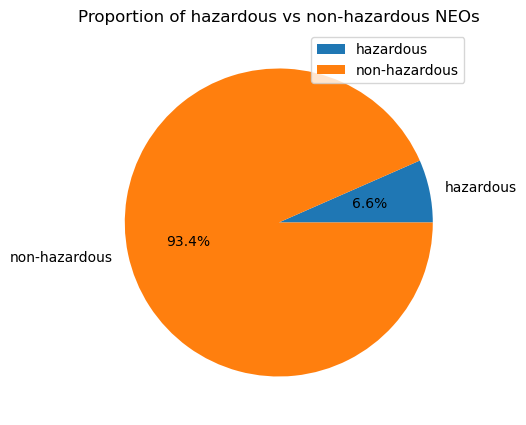

In [23]:
print("total_hazardous_count", total_hazardous_count)
print("total_non_hazardous_count", total_non_hazardous_count)
hazardous_df = pd.DataFrame({'count': [total_hazardous_count, total_non_hazardous_count]}, index=['hazardous', 'non-hazardous'])
hazardous_plot = hazardous_df.plot.pie(y='count', ylabel='', figsize=(5,5), autopct='%1.1f%%', title="Proportion of hazardous vs non-hazardous NEOs")

In [32]:
from src.utils import display_hazardous_proportion
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# make plot data
hazardous_list = []
total_neos_counted = []
haz1 = []
haz2 = []
haz3 = []

# have a point every 5m to reduce clutter
for i in range(600): # 600 chosen as only 7 data points above 3000m diameter, thus those 7 are filtered
    hazardous_proportion_result = display_hazardous_proportion(full_relevant_approach_df, 5*i, False)
    hazardous_list.append([hazardous_proportion_result[0], hazardous_proportion_result[1]])
    total_neos_counted.append(hazardous_proportion_result[2])

    # below for making plot in below chunk of code
    haz1.append(hazardous_proportion_result[0])
    haz2.append(hazardous_proportion_result[1])
    haz3.append(hazardous_proportion_result[2])

'''
##### METHOD 1 WITHOUT TOTAL # OF NEOS IN % CALCULATION #####
# convert to df
new_hazardous_df = pd.DataFrame(hazardous_list, columns=['average approach distance', 'hazardous proportion'])

# plot lower limit and hazardous percentage
hazardous_fig = px.line(new_hazardous_df, x='average approach distance', y='hazardous proportion', 
                        title='Hazardous asteroid proportion vs asteroid size lower limit',
                        labels={
                            "average approach distance": "NEO size - average diameter lower bound (m)",
                            "hazardous proportion": "Hazardous asteroid proportion",
                        })
hazardous_fig.show()
##### END METHOD 1 #####
'''

##### METHOD 2 BASED ON FEEDBACK DURING PRESENTATION #####
# Create figure with secondary y-axis
hazardous_fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
hazardous_fig.add_trace(
    go.Scatter(x=haz1, y=haz2, name="Hazardous percentage"),
    secondary_y=False,
)

hazardous_fig.add_trace(
    go.Scatter(x=haz1, y=haz3, name="Number of NEOs"),
    secondary_y=True,
)

# Add figure title
hazardous_fig.update_layout(
    title_text="Hazardous asteroid proportion vs asteroid size lower limit"
)

# Set x-axis title
hazardous_fig.update_xaxes(title_text="NEO size - average diameter lower bound (m)")

# Set y-axes titles
hazardous_fig.update_yaxes(title_text="Hazardous asteroid proportion", secondary_y=False)
hazardous_fig.update_yaxes(title_text="Total number of NEOs in proportion %", secondary_y=True)

hazardous_fig.show()
##### END METHOD 2 #####

# export for viewing in html
hazardous_fig.write_html("neo_size_lower_limit_vs_hazardous_proportion.html")

In [24]:
# an interesting plot created from seeing which features had high correlation

size_mag_fig = px.scatter(full_relevant_approach_df, x='estimated_diameter.meters.estimated_diameter_avg', y='absolute_magnitude_h', 
                        color='is_potentially_hazardous_asteroid', 
                        color_discrete_sequence=["green", "red"],
                        title='Absolute magnitude vs NEO size',
                        labels={
                            "estimated_diameter.meters.estimated_diameter_avg": "NEO size - average diameter (m)",
                            "absolute_magnitude_h": "Absolute magnitude (H)",
                        })
size_mag_fig.update_layout(legend_title="Hazardous asteroid")
size_mag_fig.show()

# export for viewing in html
size_mag_fig.write_html("neo_size_vs_absolute_mag.html")

#### Task 4.2, 4.3 & 4,4:
- (Create a scatter plot of the correlation between NEO size and close approach distance.)
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

In [25]:
# use plotly express for interactive scatterplot
fig = px.scatter(full_relevant_approach_df, x='estimated_diameter.meters.estimated_diameter_avg', y='miss_distance.kilometers', color='is_potentially_hazardous_asteroid', 
                 color_discrete_sequence=["green", "red"],
                #  size='absolute_magnitude_h',
                 hover_data=['close_approach_date', 'orbiting_body', 'relative_velocity.kilometers_per_second', 'name', 'absolute_magnitude_h', 'estimated_diameter.meters.estimated_diameter_min', 'estimated_diameter.meters.estimated_diameter_max'], 
                 labels={
                     "estimated_diameter.meters.estimated_diameter_avg": "NEO size - average diameter (m)",
                     "miss_distance.kilometers": "Close approach distance (km)",
                 },
                 title="NEO size vs close approach distance")
fig.update_layout(legend_title="Hazardous asteroid")
fig.show()

# export for viewing in html
fig.write_html("neo_size_vs_close_approach_distance.html")

### Task 5: Interpretation of Results

- Interpret the results of your data visualization in part A and B.
- What insights can you gain about NEOs from your results? Summarizing your findings.
- Use your findings to make predictions or recommendations. For example, if you found that larger NEOs are more likely to be potentially hazardous, you could recommend that more resources be allocated to tracking large NEOs. Be creative!
- Identify, understand, and explain one scientific paper, on a clustering or classification method of relevance that could help Task 5. You don't have to implement it, you just need to justify in this notebook why the method in the scientific paper could contribute in analysis or interpretation of the results.

With regards to a relation between NEO size and its danger, there are no hazardous asteroids with a NEO size less than 150m in average diameter. A hazardous asteroid proportion vs asteroid size lower limit plot was created to see the effect of gradually increasing the lower bound on asteroid size on the hazardous proportion, and a proportion of 23%-30% was consistent from 100m to 2000m. Exploring which features had higher correlations prompted us to create a scatter plot of absolute magnitude vs NEO size. 

The utilization of these visualization tools has greatly enhanced our understanding of Near-Earth Objects (NEOs) and their potential hazards. However, we can further improve the accuracy and reliability of our findings by incorporating machine learning classification methods. By integrating these advanced techniques, our predictions regarding the hazardous nature of NEOs can become even more precise and trustworthy.

One such paper informative in this regard is titled "Classifying Hazardous and Non-Hazardous Asteroids Using Machine Learning", available at https://nhsjs.com/2022/classifying-hazardous-and-non-hazardous-asteroids-using-machine-learning/?fbclid=IwAR1plLTfsKZU7rybFOgsxOaCMNtHdzZ3ytlzn5aGd0QF3-7WGCSs4p9O8vM. 

### Task 6: Presentation and Documentation

- Make this project as part of your presentation, **using beamer in LaTeX**. 
- This should include an overview of your work, the results of your data analysis, and the insights you gained from your results.

Please find our presentation in our GitHub repo. 